# Overview for Dilated CNN

# Preparation (RUN ALL)

## Hyperparameters (tunable)

Some of the tunable parameters are hidden in side the code blocks, eg.

- [change learning rate scheduler](https://colab.research.google.com/drive/1ObiicTOnIh3rf9kPfQ6inWMeSHe4dDUB#scrollTo=q33NkT-xTORX&line=30&uniqifier=1)
- after pre-trained and fine tuned, the necessary parameters should be updated in the [last part](#Test-for-given-unknown-test-set)

In [1]:
window_len_sec = 10; # 25,10,5,2,1 sec can be evaluated
evaluated_SNR = 100;
epochs=200;
normalization=True;
# parameters regarding to model
filters = 1
batch_size = 128
experiment_index = 5
layers=3
kernel_size=3
filters_spatial=8
filters_dilated=16

## Hyperparameters (no tune)

In [2]:
checkpoint_save_dir  = '/content/drive/MyDrive/PD/checkpoints/dilated/'
SNR_100_mat_path='/content/drive/MyDrive/PD/dataset_CNN_SNR_100.mat'
SNR_4_mat_path='/content/drive/MyDrive/PD/dataset_CNN_SNR_4.mat'
model_save_dir='/content/drive/MyDrive/PD/model/dilated/'
test_subj_1_37_mat_path='/content/drive/MyDrive/PD/preprocessed_CNN_test_sub_1_37'
test_subj_40_41_42_mat_path='/content/drive/MyDrive/PD/preprocessed_CNN_test_sub_40_41_42'
test_subjs = [test_subj_1_37_mat_path, test_subj_40_41_42_mat_path]
downsample_freq_CNN = 70
window_len_samples = window_len_sec * downsample_freq_CNN # 700

## Libraries

In [3]:
# imports and directories
from scipy.io import loadmat
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Activation
from keras import regularizers
import tensorflow as tf 
from tensorflow.python.ops.linalg_ops import norm
import h5py
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount("/content/drive")
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, load_model
import os

Mounted at /content/drive


## Callbacks

- learning rate scheduler set to `(0, 0.2), (20, 0.1), (40, 0.05), 80, 0.02)`
- early stopping monitors validation loss, if no consecutive improvements after 10 epochs, then the training process is stopped.
- checkpoint: nothing tunable.

#### Learning Rate Scheduler

In [4]:
class CustomLearningRateScheduler(keras.callbacks.Callback):

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("Learning rate is %6.4f." % (scheduled_lr))

LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 0.2),
    (20, 0.1),
    (40, 0.05),
    (80, 0.02),
] 
# Used in pretraining, updated in subject-specific retraining. The learning rate
# is divided by 10 during subject-specific retraining. 

def lr_schedule(epoch, lr):
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
          return LR_SCHEDULE[i][1]
    return lr # if loss stagnate, return lr * 0.1

### Early Stopping

In [5]:
early_stopping = EarlyStopping(monitor="val_acc",
                               min_delta=0, # no loss reduction
                               patience=10, # 10 non-consecutive epochs
                               verbose=1,
                               mode="max",
                               restore_best_weights=True,
                               )

### Model Checkpoint

In [6]:
checkpoint_pre_train = ModelCheckpoint(filepath = checkpoint_save_dir + 'exp_' + str(experiment_index) +'_pretrained_epoch_{epoch:02d}_val_acc{val_acc:.2f}.h5',
                             monitor='val_acc', 
                             verbose=2, 
                             save_best_only=True, 
                             mode='max')
checkpoint_fine_tune = ModelCheckpoint(filepath = checkpoint_save_dir + 'exp_' + str(experiment_index) +'_finetuned_epoch_{epoch:02d}_val_acc{val_acc:.2f}.h5',
                             monitor='val_acc', 
                             verbose=2, 
                             save_best_only=True, 
                             mode='max')

### Finale: Callback List

In [7]:
callbacks_list_pre_train = [CustomLearningRateScheduler(lr_schedule), checkpoint_pre_train, early_stopping]
callbacks_list_fine_tune = [CustomLearningRateScheduler(lr_schedule), checkpoint_fine_tune, early_stopping]

## Model (dilated CNN)

In [8]:
def dilated_model(time_window=640, layers=3, kernel_size=3, spatial_filters=8, dilated_filters=16, activation="relu",
                  compile=True, inputs=tuple(), output_name="output"):

    # If different inputs are required
    if len(inputs) == 3:
        eeg, env1, env2 = inputs[0], inputs[1], inputs[2]
    else:
        eeg = tf.keras.layers.Input(shape=[time_window, 64])
        env1 = tf.keras.layers.Input(shape=[time_window, 1])
        env2 = tf.keras.layers.Input(shape=[time_window, 1])

    # Activations to apply
    if isinstance(activation, str):
        activations = [activation] * layers
    else:
        activations = activation

    env_proj_1 = env1
    env_proj_2 = env2
    # Spatial convolution
    eeg_proj_1 = tf.keras.layers.Conv1D(spatial_filters, kernel_size=1,name='spatial_convolution')(eeg)

    # Construct dilated layers
    for l in range(layers):
        # dilated on EEG
        eeg_proj_1 = tf.keras.layers.Conv1D(dilated_filters, kernel_size=kernel_size, dilation_rate=kernel_size ** l,
                                            strides=1, activation=activations[l])(eeg_proj_1)

        # dilated on envelope data, share weights
        env_proj_layer = tf.keras.layers.Conv1D(dilated_filters, kernel_size=kernel_size, dilation_rate=kernel_size ** l,
                                                strides=1, activation=activations[l])
        env_proj_1 = env_proj_layer(env_proj_1)
        env_proj_2 = env_proj_layer(env_proj_2)

    # Comparison
    cos1 = tf.keras.layers.Dot(1, normalize=True)([eeg_proj_1, env_proj_1])
    cos2 = tf.keras.layers.Dot(1, normalize=True)([eeg_proj_1, env_proj_2])

    # Classification
    out1 = tf.keras.layers.Dense(1, activation="sigmoid")(
        tf.keras.layers.Flatten()(tf.keras.layers.Concatenate()([cos1, cos2])))

    # 1 output per batch
    out = tf.keras.layers.Reshape([1], name=output_name)(out1)

    model = tf.keras.Model(inputs=[eeg, env1, env2], outputs=[out])
    if compile:
        model.compile(optimizer=tf.keras.optimizers.Adam(), metrics=["acc"], loss=["binary_crossentropy"])
        print(model.summary())
    return model

# To check the model summary:
model = dilated_model(window_len_samples, layers, kernel_size)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 700, 64)]    0           []                               
                                                                                                  
 spatial_convolution (Conv1D)   (None, 700, 8)       520         ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 700, 1)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 700, 1)]     0           []                               
                                                                                              

# Pre Train (SNR 100)

## Dataset Loading (SNR 100)

Information of `dataset_CNN_SNR_100.mat`:
- contains: 
  - `EEG_SNR_100_train_set`: 80% of the preprocessed EEG trials with SNR of 100.
  - `env_attended_SNR_100_train_set`
  - `env_unattended_SNR_100_train_set`  
  - `EEG_SNR_100_test_set`: 20% of the preprocessed EEG trials with SNR of 100. Randomly chosen and different from training set.
  - `env_attended_SNR_100_test_set`
  - `env_unattended_SNR_100_test_set`


In [ ]:
# load dataset
mat_path = SNR_100_mat_path
print("INFO: loading dataset SNR 100", mat_path)
mat_contents = loadmat(mat_path)
EEG_test = mat_contents['EEG_SNR_100_test_set']
env_attended_test = mat_contents['env_attended_SNR_100_test_set']
env_unattended_test = mat_contents['env_unattended_SNR_100_test_set']
EEG_train = mat_contents['EEG_SNR_100_train_set']
env_attended_train = mat_contents['env_attended_SNR_100_train_set']
env_unattended_train = mat_contents['env_unattended_SNR_100_train_set']
print("size of EEG train is", EEG_train.shape)
print("size of attended env train is", env_attended_train.shape)
print("size of unattended env train is", env_unattended_train.shape)
print("size of EEG test is", EEG_test.shape)
print("size of attended env test is", env_attended_test.shape)
print("size of unattended env test is", env_unattended_test.shape)

INFO: loading dataset SNR 100 /content/drive/MyDrive/PD/dataset_CNN_SNR_100.mat
size of EEG train is (692, 3500, 64)
size of attended env train is (692, 3500)
size of unattended env train is (692, 3500)
size of EEG test is (172, 3500, 64)
size of attended env test is (172, 3500)
size of unattended env test is (172, 3500)


In [ ]:
# arrange this to specific window length
print("INFO: resizing dataset to window length of", window_len_sec, 'seconds')
EEG_test.resize(EEG_test.shape[0]*int(EEG_test.shape[1]/window_len_samples), window_len_samples, EEG_test.shape[2])
env_attended_test.resize(env_attended_test.shape[0]*int(env_attended_test.shape[1]/window_len_samples), window_len_samples)
env_unattended_test.resize(env_unattended_test.shape[0]*int(env_unattended_test.shape[1]/window_len_samples), window_len_samples)
EEG_train.resize(EEG_train.shape[0]*int(EEG_train.shape[1]/window_len_samples), window_len_samples, EEG_train.shape[2])
env_attended_train.resize(env_attended_train.shape[0]*int(env_attended_train.shape[1]/window_len_samples), window_len_samples)
env_unattended_train.resize(env_unattended_train.shape[0]*int(env_unattended_train.shape[1]/window_len_samples), window_len_samples)
print("size of EEG train is ", EEG_train.shape)
print("size of attended env train is ", env_attended_train.shape)
print("size of unattended env train is ", env_unattended_train.shape)
print("size of EEG test is ", EEG_test.shape)
print("size of attended env test is ", env_attended_test.shape)
print("size of unattended env test is ", env_unattended_test.shape)

INFO: resizing dataset to window length of 10 seconds
size of EEG train is  (3460, 700, 64)
size of attended env train is  (3460, 700)
size of unattended env train is  (3460, 700)
size of EEG test is  (860, 700, 64)
size of attended env test is  (860, 700)
size of unattended env test is  (860, 700)


In [ ]:
# equalize or balance the dataset
def batch_equalizer(eeg, env1, env2, labels):
    # present each of the eeg segments twice, where the envelopes, and thus the labels 
    # are swapped around. EEG presented in small segments [bs, window_length, 64]
    return np.concatenate([eeg,eeg], axis=0), np.concatenate([env1, env2], axis=0),np.concatenate([env2, env1], axis=0), np.concatenate([labels, (labels+1)%2], axis=0)
print("INFO: balancing dataset")
labels_test = np.zeros((EEG_test.shape[0],1))
EEG_test, env_attended_test, env_unattended_test, labels_test = batch_equalizer(EEG_test, env_attended_test, env_unattended_test, labels_test)
labels_train = np.zeros((EEG_train.shape[0],1))
EEG_train, env_attended_train, env_unattended_train, labels_train = batch_equalizer(EEG_train, env_attended_train, env_unattended_train, labels_train)
print("size of EEG train is ", EEG_train.shape)
print("size of attended env train is ", env_attended_train.shape)
print("size of unattended env train is ", env_unattended_train.shape)
print("size of EEG test is ", EEG_test.shape)
print("size of attended env test is ", env_attended_test.shape)
print("size of unattended env test is ", env_unattended_test.shape)

INFO: balancing dataset
size of EEG train is  (6920, 700, 64)
size of attended env train is  (6920, 700)
size of unattended env train is  (6920, 700)
size of EEG test is  (1720, 700, 64)
size of attended env test is  (1720, 700)
size of unattended env test is  (1720, 700)


In [ ]:
# normalize the dataset. be careful not to useall the ram up!!! or it will crash!!!
# I can do a better normalization, but it requires RAM size. 
if normalization is True:
  all_EEG = np.concatenate((EEG_train, EEG_test), axis=0)
  all_env = np.concatenate((env_attended_train, env_unattended_train, env_attended_test, env_unattended_test), axis=0)
  print("INFO: before normalization")
  print("size of all_EEG: ", all_EEG.shape)
  print("size of all_env: ", all_env.shape)
  print("mean of all_EEG: ", np.mean(all_EEG), ". std of all_EEG: ", np.std(all_EEG))
  print("mean of all_env: ", np.mean(all_env), ". std of all_env: ", np.std(all_env))
  print("mean of EEG_train: ", np.mean(EEG_train), ". std of EEG_train: ", np.std(EEG_train))
  print("mean of env_attended_train: ", np.mean(env_attended_train), ". std of EEG_train: ", np.std(env_attended_train))
  print("mean of env_unattended_train: ", np.mean(env_unattended_train), ". std of EEG_train: ", np.std(env_unattended_train))
  print("mean of EEG_test: ", np.mean(EEG_test), ". std of EEG_train: ", np.std(EEG_test))
  print("mean of env_attended_test: ", np.mean(env_attended_test), ". std of EEG_train: ", np.std(env_attended_test))
  print("mean of env_unattended_test: ", np.mean(env_unattended_test), ". std of EEG_train: ", np.std(env_unattended_test))
  EEG_train = EEG_train / np.std(all_EEG)
  EEG_test = EEG_test / np.std(all_EEG)
  env_attended_train = env_attended_train / np.std(all_env)
  env_unattended_train = env_unattended_train / np.std(all_env)
  env_attended_test = env_attended_test / np.std(all_env)
  env_unattended_test = env_unattended_test / np.std(all_env)
  print("INFO: after normalization")
  print("mean of EEG_train: ", np.mean(EEG_train), ". std of EEG_train: ", np.std(EEG_train))
  print("mean of env_attended_train: ", np.mean(env_attended_train), ". std of EEG_train: ", np.std(env_attended_train))
  print("mean of env_unattended_train: ", np.mean(env_unattended_train), ". std of EEG_train: ", np.std(env_unattended_train))
  print("mean of EEG_test: ", np.mean(EEG_test), ". std of EEG_train: ", np.std(EEG_test))
  print("mean of env_attended_test: ", np.mean(env_attended_test), ". std of EEG_train: ", np.std(env_attended_test))
  print("mean of env_unattended_test: ", np.mean(env_unattended_test), ". std of EEG_train: ", np.std(env_unattended_test))
else:
  print("skipping normalization.")


INFO: before normalization
size of all_EEG:  (8640, 700, 64)
size of all_env:  (17280, 700)
mean of all_EEG:  2.5848933175495923e-11 . std of all_EEG:  11.380040259696543
mean of all_env:  0.0007783501517158843 . std of all_env:  0.24807946980324394
mean of EEG_train:  -7.537633431916678e-11 . std of EEG_train:  11.375468242761354
mean of env_attended_train:  0.0007321425867751914 . std of EEG_train:  0.24808747299800848
mean of env_unattended_train:  0.0007321425867751913 . std of EEG_train:  0.24808747299800868
mean of EEG_test:  4.3310407871826923e-10 . std of EEG_train:  11.398416122204138
mean of env_attended_test:  0.0009642550060121662 . std of EEG_train:  0.24804718131299952
mean of env_unattended_test:  0.0009642550060121663 . std of EEG_train:  0.2480471813129995
INFO: after normalization
mean of EEG_train:  -6.623555509002853e-12 . std of EEG_train:  0.9995982424639213
mean of env_attended_train:  0.0029512421457360645 . std of EEG_train:  1.000032260608953
mean of env_unatt

## Train (SNR 100)

### if additional pre-trained model

In [ ]:
model = load_model(checkpoint_save_dir + 'exp_5_pretrained_epoch_38_val_acc1.00.h5')

In [ ]:
history = model.fit([EEG_train, env_attended_train, env_unattended_train], 
                    labels_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    verbose=2,
                    shuffle=True,
                    callbacks=callbacks_list_pre_train)
filepath = model_save_dir + "exp_" + str(experiment_index) + "_final_pretrain.h5"
model.save(filepath)

Learning rate is 0.2000.
Epoch 1/200

Epoch 1: val_acc improved from -inf to 0.90896, saving model to /content/drive/MyDrive/PD/checkpoints/dilated/exp_5_pretrained_epoch_01_val_acc0.91.h5
44/44 - 18s - loss: 0.0163 - acc: 0.9971 - val_loss: 0.2168 - val_acc: 0.9090 - 18s/epoch - 406ms/step
Learning rate is 0.2000.
Epoch 2/200

Epoch 2: val_acc did not improve from 0.90896
44/44 - 15s - loss: 0.0746 - acc: 0.9715 - val_loss: 0.3417 - val_acc: 0.8591 - 15s/epoch - 350ms/step
Learning rate is 0.2000.
Epoch 3/200

Epoch 3: val_acc improved from 0.90896 to 0.96171, saving model to /content/drive/MyDrive/PD/checkpoints/dilated/exp_5_pretrained_epoch_03_val_acc0.96.h5
44/44 - 16s - loss: 0.0863 - acc: 0.9662 - val_loss: 0.1004 - val_acc: 0.9617 - 16s/epoch - 354ms/step
Learning rate is 0.2000.
Epoch 4/200

Epoch 4: val_acc did not improve from 0.96171
44/44 - 15s - loss: 0.0417 - acc: 0.9865 - val_loss: 0.1602 - val_acc: 0.9335 - 15s/epoch - 351ms/step
Learning rate is 0.2000.
Epoch 5/200

E

## Test (SNR 100)

In [ ]:
scores = model.evaluate([EEG_test, env_attended_test, env_unattended_test],
                        labels_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

54/54 - 2s - loss: 0.2107 - acc: 0.9320 - 2s/epoch - 29ms/step
Accuracy: 93.20%


## Visualization

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


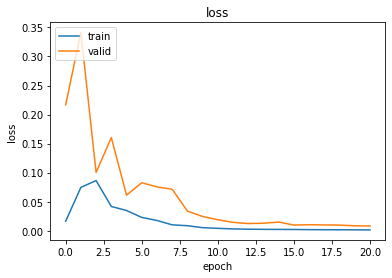

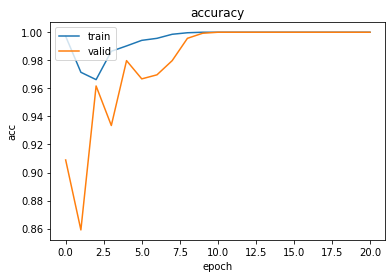

In [ ]:
print(history.history.keys())

#plt.subplot(1,2,1)        
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('accuracy')
plt.ylabel('acc')  
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## Test over best epoch

The information of best epoch can be seen in previous logs.

In [ ]:
best_model = load_model(checkpoint_save_dir + 'exp_5_pretrained_epoch_13_val_acc1.00.h5')
scores = best_model.evaluate([EEG_test, env_attended_test, env_unattended_test],
                        labels_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

54/54 - 2s - loss: 0.2206 - acc: 0.9273 - 2s/epoch - 34ms/step
Accuracy: 92.73%


# Fine-Tuning (SNR 4)

## Dalaset Loading (SNR 4)

In [ ]:
# load dataset
mat_path = SNR_4_mat_path
print("INFO: loading dataset SNR 4", mat_path)
mat_contents = loadmat(mat_path)
EEG_test = mat_contents['EEG_SNR_4_test_set']
env_attended_test = mat_contents['env_attended_SNR_4_test_set']
env_unattended_test = mat_contents['env_unattended_SNR_4_test_set']
EEG_train = mat_contents['EEG_SNR_4_train_set']
env_attended_train = mat_contents['env_attended_SNR_4_train_set']
env_unattended_train = mat_contents['env_unattended_SNR_4_train_set']
print("size of EEG train is", EEG_train.shape)
print("size of attended env train is", env_attended_train.shape)
print("size of unattended env train is", env_unattended_train.shape)
print("size of EEG test is", EEG_test.shape)
print("size of attended env test is", env_attended_test.shape)
print("size of unattended env test is", env_unattended_test.shape)

INFO: loading dataset SNR 4 /content/drive/MyDrive/PD/dataset_CNN_SNR_4.mat
size of EEG train is (701, 3500, 64)
size of attended env train is (701, 3500)
size of unattended env train is (701, 3500)
size of EEG test is (175, 3500, 64)
size of attended env test is (175, 3500)
size of unattended env test is (175, 3500)


In [ ]:
# arrange this to specific window length
print("INFO: resizing dataset to window length of", window_len_sec, 'seconds')
downsample_freq_CNN = 70
window_len_samples = window_len_sec * downsample_freq_CNN # 700
EEG_test.resize(EEG_test.shape[0]*int(EEG_test.shape[1]/window_len_samples), window_len_samples, EEG_test.shape[2])
env_attended_test.resize(env_attended_test.shape[0]*int(env_attended_test.shape[1]/window_len_samples), window_len_samples)
env_unattended_test.resize(env_unattended_test.shape[0]*int(env_unattended_test.shape[1]/window_len_samples), window_len_samples)
EEG_train.resize(EEG_train.shape[0]*int(EEG_train.shape[1]/window_len_samples), window_len_samples, EEG_train.shape[2])
env_attended_train.resize(env_attended_train.shape[0]*int(env_attended_train.shape[1]/window_len_samples), window_len_samples)
env_unattended_train.resize(env_unattended_train.shape[0]*int(env_unattended_train.shape[1]/window_len_samples), window_len_samples)
print("size of EEG train is ", EEG_train.shape)
print("size of attended env train is ", env_attended_train.shape)
print("size of unattended env train is ", env_unattended_train.shape)
print("size of EEG test is ", EEG_test.shape)
print("size of attended env test is ", env_attended_test.shape)
print("size of unattended env test is ", env_unattended_test.shape)

INFO: resizing dataset to window length of 10 seconds
size of EEG train is  (3505, 700, 64)
size of attended env train is  (3505, 700)
size of unattended env train is  (3505, 700)
size of EEG test is  (875, 700, 64)
size of attended env test is  (875, 700)
size of unattended env test is  (875, 700)


In [ ]:
# equalize or balance the dataset
def batch_equalizer(eeg, env1, env2, labels):
    # present each of the eeg segments twice, where the envelopes, and thus the labels 
    # are swapped around. EEG presented in small segments [bs, window_length, 64]
    return np.concatenate([eeg,eeg], axis=0), np.concatenate([env1, env2], axis=0),np.concatenate([env2, env1], axis=0), np.concatenate([labels, (labels+1)%2], axis=0)
print("INFO: balancing dataset")
labels_test = np.zeros((EEG_test.shape[0],1))
EEG_test, env_attended_test, env_unattended_test, labels_test = batch_equalizer(EEG_test, env_attended_test, env_unattended_test, labels_test)
labels_train = np.zeros((EEG_train.shape[0],1))
EEG_train, env_attended_train, env_unattended_train, labels_train = batch_equalizer(EEG_train, env_attended_train, env_unattended_train, labels_train)
print("size of EEG train is ", EEG_train.shape)
print("size of attended env train is ", env_attended_train.shape)
print("size of unattended env train is ", env_unattended_train.shape)
print("size of EEG test is ", EEG_test.shape)
print("size of attended env test is ", env_attended_test.shape)
print("size of unattended env test is ", env_unattended_test.shape)

INFO: balancing dataset
size of EEG train is  (7010, 700, 64)
size of attended env train is  (7010, 700)
size of unattended env train is  (7010, 700)
size of EEG test is  (1750, 700, 64)
size of attended env test is  (1750, 700)
size of unattended env test is  (1750, 700)


In [ ]:
# normalize the dataset. be careful not to useall the ram up!!! or it will crash!!!
# I can do a better normalization, but it requires RAM size. 
if normalization is True:
  all_EEG = np.concatenate((EEG_train, EEG_test), axis=0)
  all_env = np.concatenate((env_attended_train, env_unattended_train, env_attended_test, env_unattended_test), axis=0)
  print("INFO: before normalization")
  print("size of all_EEG: ", all_EEG.shape)
  print("size of all_env: ", all_env.shape)
  print("mean of all_EEG: ", np.mean(all_EEG), ". std of all_EEG: ", np.std(all_EEG))
  print("mean of all_env: ", np.mean(all_env), ". std of all_env: ", np.std(all_env))
  print("mean of EEG_train: ", np.mean(EEG_train), ". std of EEG_train: ", np.std(EEG_train))
  print("mean of env_attended_train: ", np.mean(env_attended_train), ". std of EEG_train: ", np.std(env_attended_train))
  print("mean of env_unattended_train: ", np.mean(env_unattended_train), ". std of EEG_train: ", np.std(env_unattended_train))
  print("mean of EEG_test: ", np.mean(EEG_test), ". std of EEG_train: ", np.std(EEG_test))
  print("mean of env_attended_test: ", np.mean(env_attended_test), ". std of EEG_train: ", np.std(env_attended_test))
  print("mean of env_unattended_test: ", np.mean(env_unattended_test), ". std of EEG_train: ", np.std(env_unattended_test))
  EEG_train = EEG_train / np.std(all_EEG)
  EEG_test = EEG_test / np.std(all_EEG)
  env_attended_train = env_attended_train / np.std(all_env)
  env_unattended_train = env_unattended_train / np.std(all_env)
  env_attended_test = env_attended_test / np.std(all_env)
  env_unattended_test = env_unattended_test / np.std(all_env)
  print("INFO: after normalization")
  print("mean of EEG_train: ", np.mean(EEG_train), ". std of EEG_train: ", np.std(EEG_train))
  print("mean of env_attended_train: ", np.mean(env_attended_train), ". std of EEG_train: ", np.std(env_attended_train))
  print("mean of env_unattended_train: ", np.mean(env_unattended_train), ". std of EEG_train: ", np.std(env_unattended_train))
  print("mean of EEG_test: ", np.mean(EEG_test), ". std of EEG_train: ", np.std(EEG_test))
  print("mean of env_attended_test: ", np.mean(env_attended_test), ". std of EEG_train: ", np.std(env_attended_test))
  print("mean of env_unattended_test: ", np.mean(env_unattended_test), ". std of EEG_train: ", np.std(env_unattended_test))
else:
  print("skipping normalization.")


INFO: before normalization
size of all_EEG:  (8760, 700, 64)
size of all_env:  (17520, 700)
mean of all_EEG:  -9.563519689296737e-12 . std of all_EEG:  11.662852220826007
mean of all_env:  0.0007785422569662596 . std of all_env:  0.24805688666627107
mean of EEG_train:  -3.7722206234015986e-10 . std of EEG_train:  11.665000954945544
mean of env_attended_train:  0.0007850060142212136 . std of EEG_train:  0.24802928427094356
mean of env_unattended_train:  0.0007850060142212131 . std of EEG_train:  0.24802928427094362
mean of EEG_test:  1.4631715648142883e-09 . std of EEG_train:  11.654241033976168
mean of env_attended_test:  0.000752650292190699 . std of EEG_train:  0.24816742150794707
mean of env_unattended_test:  0.0007526502921906989 . std of EEG_train:  0.24816742150794716
INFO: after normalization
mean of EEG_train:  -3.2343894851765015e-11 . std of EEG_train:  1.000184237447143
mean of env_attended_train:  0.003164620925349831 . std of EEG_train:  0.9998887255431667
mean of env_unat

## Load the best model (ATTENTION)

In [ ]:
pretrained_model=load_model(checkpoint_save_dir + 'exp_5_pretrained_epoch_13_val_acc1.00.h5')

## Train (SNR 4)

In [ ]:
history = pretrained_model.fit([EEG_train, env_attended_train, env_unattended_train], 
                    labels_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    verbose=2,
                    shuffle=True,
                    callbacks=callbacks_list_fine_tune)
filepath = model_save_dir + "finetune_for_low_SNR.h5"
pretrained_model.save(filepath)

Learning rate is 0.2000.
Epoch 1/200

Epoch 1: val_acc improved from -inf to 0.15121, saving model to /content/drive/MyDrive/PD/checkpoints/dilated/exp_5_finetuned_epoch_01_val_acc0.15.h5
44/44 - 20s - loss: 1.1567 - acc: 0.5663 - val_loss: 1.2284 - val_acc: 0.1512 - 20s/epoch - 461ms/step
Learning rate is 0.2000.
Epoch 2/200

Epoch 2: val_acc improved from 0.15121 to 0.51355, saving model to /content/drive/MyDrive/PD/checkpoints/dilated/exp_5_finetuned_epoch_02_val_acc0.51.h5
44/44 - 16s - loss: 0.6240 - acc: 0.6558 - val_loss: 0.7381 - val_acc: 0.5136 - 16s/epoch - 371ms/step
Learning rate is 0.2000.
Epoch 3/200

Epoch 3: val_acc did not improve from 0.51355
44/44 - 16s - loss: 0.5940 - acc: 0.6790 - val_loss: 0.7873 - val_acc: 0.4800 - 16s/epoch - 364ms/step
Learning rate is 0.2000.
Epoch 4/200

Epoch 4: val_acc did not improve from 0.51355
44/44 - 16s - loss: 0.5602 - acc: 0.7063 - val_loss: 0.8740 - val_acc: 0.4365 - 16s/epoch - 365ms/step
Learning rate is 0.2000.
Epoch 5/200

Epo

## Test (SNR 4)

In [ ]:
scores = pretrained_model.evaluate([EEG_test, env_attended_test, env_unattended_test],
                                  labels_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

55/55 - 2s - loss: 1.0163 - acc: 0.7697 - 2s/epoch - 33ms/step
Accuracy: 76.97%


## Visualization

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


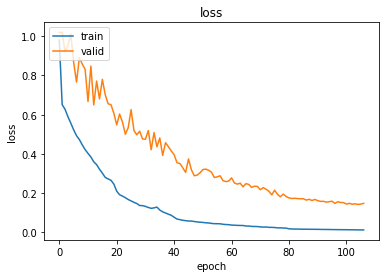

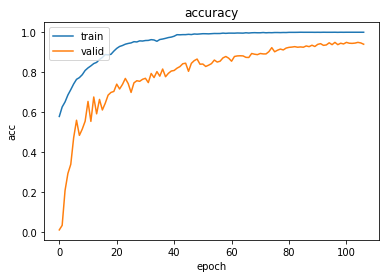

In [ ]:
print(history.history.keys())

#plt.subplot(1,2,1)        
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('accuracy')
plt.ylabel('acc')  
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Test for given unknown test set

## evaluate SNR 100 (`pretrained_model`)

In [ ]:
pretrained_model = load_model(checkpoint_save_dir + 'exp_5_pretrained_epoch_13_val_acc1.00.h5')
for test_subj in test_subjs:
  for name_subject in os.listdir(test_subj):
    filename = os.fsdecode(name_subject)
    if filename == '.DS_Store':
      continue
    dir_subject = test_subj + '/' + filename
    for name_trial in os.listdir(dir_subject):
      trialname = os.fsdecode(name_trial)
      dir_trial = dir_subject + '/' + trialname
      trial = loadmat(dir_trial)
      trial = trial['trial']
      FileHeader = trial['FileHeader']
      SNR = FileHeader[0, 0]['SNR'][0][0][0][0]
      if SNR == 100:
        print('sub', filename,'\t ', end='')
        print(trialname, '\t ', end='')
        EEG = trial['ProcessedEegData'][0][0]
        track1 = trial['Processedtrack1'][0][0]
        track2 = trial['Processedtrack2'][0][0]
        EEG = EEG[0:700,:]
        track1 = track1[0:700,:]
        track2 = track2[0:700,:]
        EEG = EEG.reshape(1, 700, 64)
        track1 = track1.reshape(1, 700)
        track2 = track2.reshape(1, 700)
        score = pretrained_model.predict([EEG, track1, track2])
        score = score[0][0]
        if score<0.5:
          score = 1
        elif score <=1:
          score = 2
        else:
          print("error, score=",score)
        print(score,' ')

sub 025 	 trial-10.mat 	 1  
sub 025 	 trial-13.mat 	 1  
sub 025 	 trial-14.mat 	 2  
sub 025 	 trial-16.mat 	 1  
sub 025 	 trial-18.mat 	 2  
sub 025 	 trial-2.mat 	 1  
sub 025 	 trial-27.mat 	 1  
sub 025 	 trial-26.mat 	 1  
sub 025 	 trial-30.mat 	 2  
sub 025 	 trial-31.mat 	 2  
sub 025 	 trial-33.mat 	 2  
sub 025 	 trial-36.mat 	 2  
sub 025 	 trial-37.mat 	 2  
sub 025 	 trial-38.mat 	 2  
sub 025 	 trial-39.mat 	 2  
sub 025 	 trial-42.mat 	 2  
sub 025 	 trial-43.mat 	 2  
sub 025 	 trial-45.mat 	 2  
sub 025 	 trial-46.mat 	 1  
sub 025 	 trial-47.mat 	 1  
sub 025 	 trial-5.mat 	 2  
sub 025 	 trial-48.mat 	 1  
sub 025 	 trial-6.mat 	 2  
sub 025 	 trial-8.mat 	 1  
sub 023 	 trial-10.mat 	 1  
sub 023 	 trial-1.mat 	 2  
sub 023 	 trial-11.mat 	 1  
sub 023 	 trial-17.mat 	 1  
sub 023 	 trial-25.mat 	 1  
sub 023 	 trial-28.mat 	 2  
sub 023 	 trial-32.mat 	 2  
sub 023 	 trial-33.mat 	 1  
sub 023 	 trial-35.mat 	 1  
sub 023 	 trial-36.mat 	 2  
sub 023 	 trial-6.m

## evaluate SNR 4 (`finetuned_model`)

In [ ]:
finetuned_model = load_model(checkpoint_save_dir + 'exp_5_finetuned_epoch_97_val_acc0.95.h5')
for test_subj in test_subjs:
  for name_subject in os.listdir(test_subj):
    filename = os.fsdecode(name_subject)
    if filename == '.DS_Store':
      continue
    dir_subject = test_subj + '/' + filename
    for name_trial in os.listdir(dir_subject):
      trialname = os.fsdecode(name_trial)
      dir_trial = dir_subject + '/' + trialname
      trial = loadmat(dir_trial)
      trial = trial['trial']
      FileHeader = trial['FileHeader']
      SNR = FileHeader[0, 0]['SNR'][0][0][0][0]
      if SNR == 4:
        print('sub', filename,'\t ', end='')
        print(trialname, '\t ', end='')
        EEG = trial['ProcessedEegData'][0][0]
        track1 = trial['Processedtrack1'][0][0]
        track2 = trial['Processedtrack2'][0][0]
        EEG = EEG[0:700,:]
        track1 = track1[0:700,:]
        track2 = track2[0:700,:]
        EEG = EEG.reshape(1, 700, 64)
        track1 = track1.reshape(1, 700)
        track2 = track2.reshape(1, 700)
        score = finetuned_model.predict([EEG, track1, track2])
        score = score[0][0]
        if score<0.5:
          score = 1
        elif score <=1:
          score = 2
        else:
          print("error, score=",score)
        print(score,' ')

sub 025 	 trial-1.mat 	 2  
sub 025 	 trial-11.mat 	 1  
sub 025 	 trial-12.mat 	 1  
sub 025 	 trial-15.mat 	 1  
sub 025 	 trial-17.mat 	 2  
sub 025 	 trial-19.mat 	 2  
sub 025 	 trial-20.mat 	 1  
sub 025 	 trial-21.mat 	 1  
sub 025 	 trial-22.mat 	 1  
sub 025 	 trial-24.mat 	 2  
sub 025 	 trial-23.mat 	 2  
sub 025 	 trial-25.mat 	 2  
sub 025 	 trial-29.mat 	 1  
sub 025 	 trial-28.mat 	 1  
sub 025 	 trial-3.mat 	 1  
sub 025 	 trial-32.mat 	 2  
sub 025 	 trial-34.mat 	 2  
sub 025 	 trial-35.mat 	 2  
sub 025 	 trial-4.mat 	 1  
sub 025 	 trial-40.mat 	 2  
sub 025 	 trial-41.mat 	 1  
sub 025 	 trial-44.mat 	 2  
sub 025 	 trial-7.mat 	 2  
sub 025 	 trial-9.mat 	 2  
sub 023 	 trial-12.mat 	 2  
sub 023 	 trial-13.mat 	 2  
sub 023 	 trial-15.mat 	 1  
sub 023 	 trial-14.mat 	 1  
sub 023 	 trial-16.mat 	 2  
sub 023 	 trial-18.mat 	 1  
sub 023 	 trial-19.mat 	 1  
sub 023 	 trial-2.mat 	 2  
sub 023 	 trial-20.mat 	 1  
sub 023 	 trial-22.mat 	 1  
sub 023 	 trial-21.m